In [2]:
from model import VAE
import pandas as pd
from utils import *
from dataprep import full_preproccessing

from torch.utils.data import DataLoader

In [10]:
data = pd.read_csv('ml-1m.csv')
data.rename(columns = {'userId' : 'userid', 'movieId' : 'movieid'}, inplace = True)

In [11]:
training, testset_valid, holdout_valid, testset, holdout, data_description, data_index = full_preproccessing(data)

There are 6040 users
Filtered 93 invalid observations.


In [22]:
# answer = binary matrix (no ratings)
class MVDataset(Dataset):
    def __init__(self, data, data_description):
        useridx = data[data_description['users']].values
        itemidx = data[data_description['items']].values
        feedbackidx = data[data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)
        
#         self.tensor = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
#                                             size=torch.Size((data_description["n_users"], data_description["n_items"], data_description['n_ratings'])))
        self.matrix = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32)
        

    def __len__(self):
        return self.matrix.shape[0]

    def __getitem__(self, idx):
        return self.matrix[idx], self.matrix[idx]

In [23]:
train_dataset = MVDataset(training, data_description)

In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [33]:
for batch in train_dataloader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([16, 3403])
torch.Size([16, 3403])


In [34]:
model = VAE(200, 100, data_description['n_items'])

In [47]:
model(batch[0].to_dense(), calculate_loss=False, beta=0.5, gamma=0.005, dropout_rate=0.5).shape

torch.Size([16, 3403])

In [45]:
batch[0].to_dense()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

There are 6040 users
Filtered 93 invalid observations.
device: cuda:0
Batch size: 500
Hidden sizes: (16, 16, 0.001)


D:\GitHub\Thesis_2023\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))


Results for alpha=2
HR@5:0.012903225806451613, MRR@5: 0.007057673509286411, Coverage@5: 0.022039377020276227, NCDG@5: 0.0084717474877988, HR_pos@5: 0.012903225806451613, HR_neg@5: 0.0, MRR_pos@5: 0.007057673509286411, MRR_neg@5: 0.0, NCDG_pos@5: 0.0084717474877988, NDCG_neg@5: 0.0, Matthews@5: 0.02868981761193846
HR@10:0.026392961876832845, MRR@10: 0.008843271423916584, Coverage@10: 0.031148986188657066, NCDG@10: 0.01282148143787158, HR_pos@10: 0.026392961876832845, HR_neg@10: 0.0, MRR_pos@10: 0.008843271423916584, MRR_neg@10: 0.0, NCDG_pos@10: 0.01282148143787158, NDCG_neg@10: 0.0, Matthews@10: 0.04131528165548907
HR@20:0.04633431085043988, MRR@20: 0.010261027459124475, Coverage@20: 0.04878048780487805, NCDG@20: 0.017904421129985162, HR_pos@20: 0.04633431085043988, HR_neg@20: 0.0, MRR_pos@20: 0.010261027459124475, MRR_neg@20: 0.0, NCDG_pos@20: 0.017904421129985162, NDCG_neg@20: 0.0, Matthews@20: 0.05531103432672559
Results for alpha=3
HR@5:0.015835777126099706, MRR@5: 0.00841642228739

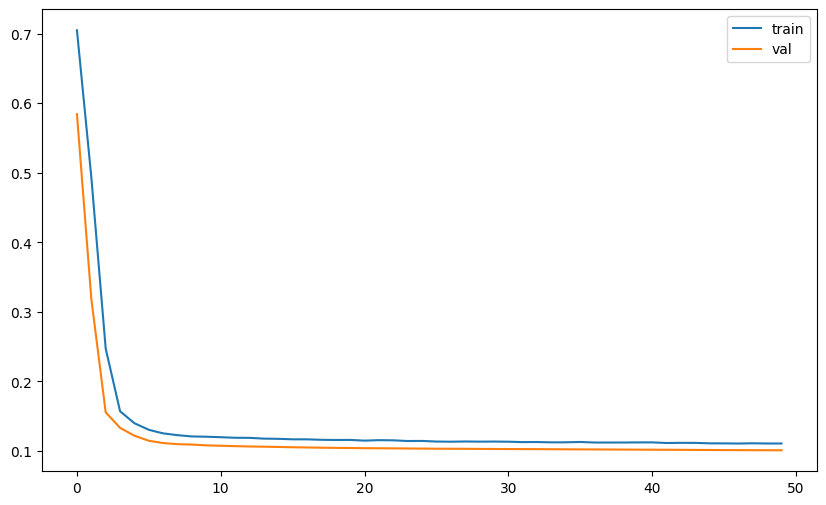

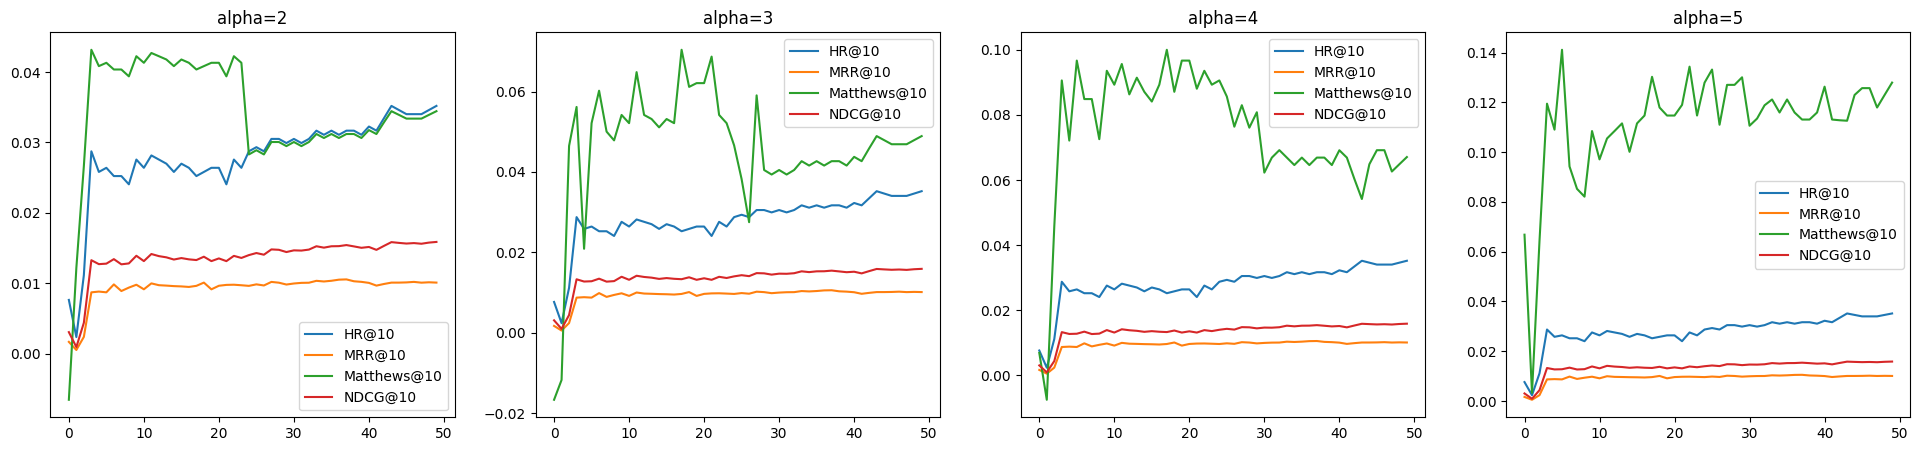

Test loss: 0.5842180252075195
Train loss: 0.7048865689171685
------------------------------

Hidden sizes: (16, 16, 0.002)


KeyboardInterrupt: 

In [3]:
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from model import VAE

from dataprep import full_preproccessing
from utils import *

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def set_random_seed(seed):
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)


# %%
# answer = binary matrix (no ratings)
class MVDataset(Dataset):
    def __init__(self, data, data_description, augment=False):
        self.augment = augment
        useridx = data[data_description['users']].values
        itemidx = data[data_description['items']].values
        values = np.ones(len(itemidx), dtype=np.float32)
        self.n_items = data_description['n_items']

        self.matrix = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                              size=torch.Size(
                                                  (data_description["n_users"], data_description["n_items"])),
                                              dtype=torch.float32)

    def __len__(self):
        return self.matrix.shape[0]

    def __getitem__(self, idx):
        if self.augment:
            num_noise = np.random.randint(0, int(0.1*self.matrix.shape[1]))
            idxs = torch.randint(0, self.matrix.shape[1], size=(num_noise,))
            noised_input = self.matrix[idx].detach().clone().to_dense()
            noised_input[idxs] = 0

            # useridx = np.zeros_like(noised_input.cpu())
            itemidx = np.arange(self.matrix.shape[1])
            noised_input = torch.sparse_coo_tensor(np.array([itemidx,]), noised_input,
                                                size=torch.Size((self.n_items,)), dtype=torch.float32)
            return noised_input, self.matrix[idx]
        else:
            return self.matrix[idx], self.matrix[idx]


# %% [markdown]


set_random_seed(42)
data = pd.read_csv('ml-1m.csv')
data.rename(columns = {'userId' : 'userid', 'movieId' : 'movieid'}, inplace = True)

# %%
training, testset_valid, holdout_valid, testset, holdout, data_description, data_index = full_preproccessing(data)
# %%
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)
# %% [markdown]

def recvae(h, data_description, device):
    h1, h2, gamma = h
    ae = VAE(h1, h2, data_description['n_items']).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters(), lr=5*10e-4)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    return ae, criterion, optimizer, scheduler

# %% [markdown]
# ### Tuning

# %%
grid1 = 2 ** np.arange(4, 11)
grid2 = 2 ** np.arange(4, 11)
gamma = 0.001 * np.arange(1, 11, 1)
grid = np.meshgrid(grid2, grid1, gamma)
grid = list(zip(grid[0].flatten(), grid[1].flatten(), grid[2].flatten()))

# %%
sizes = [500]#2 ** np.arange(4, 10)
for batch_size in sizes:
    print('Batch size:', batch_size)
    tuning_pipeline_augment(training, testset_valid, holdout_valid, data_description, recvae,
                            device, grid, MVDataset, batch_size=int(batch_size), tensor_model=False, n_epochs=50)